In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

In [2]:
def basin(left, right, bottom, top):
    #
    glbdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    #
    SUF = '.gl5'
    dtype = 'float32'
    gl5shape = (2160, 4320)
    #
    resolution = 12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    
    #------------------------------------------------------------------------------------------------------------------------

    rivnum = np.fromfile(f'{glbdir}/dat/riv_num_/rivnum.CAMA.gl5', dtype='float32').reshape(gl5shape)
    rivnum_cropped = rivnum[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    rivnum_cropped = np.ma.masked_where(rivnum_cropped == 0, rivnum_cropped)
    
    # plot
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.add_feature(cfea.LAKES, color='#d3d3d3')
    im = ax.imshow(rivnum_cropped, extent=img_extent, transform=projection, cmap='rainbow', vmin=0, vmax=50)
    fig.colorbar(im, ax=ax)

In [3]:
#---------------------------------------------------------------------------------------------------------------
#  city maskの枠だけを表示
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # right

    return ax

import random
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle

#---------------------------------------------------------------------------------------------------------------
# 流域IDと色の紐付け(kakiuchi's method) this is deprecated
#---------------------------------------------------------------------------------------------------------------

def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    return result

def is_grayish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    deviation = max(r, g, b) - min(r, g, b)
    return deviation <= 20

def is_blueish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return (b - r > 120 and b - g > 120) or (r < 100 and g< 100 and b > 150)  # If blue is dominant and significantly larger
    
def is_whitish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return  (r + g + b)/3 > 230

def get_filtered_colors():
    all_colors = list(CSS4_COLORS.values())
    result = []
    ng_color = ['#3F2E6' '#00FFFF', '#B3F2E6', '#7FFFD4', '#2A3F54', '#B3F2F9', '#00FF00']
    for color in all_colors:
        if color not in ng_color \
            and not is_grayish(color) \
            and not is_whitish(color):
            result.append(color)
    return result

def make_cmap(Rivnum_masked_array):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)

    # 流域に固有の色を割り振る
    filtered_colors = get_filtered_colors()
    #random.seed(42)
    #colors_list = (random.choices(filtered_colors, k=num_colors))
    colors_list = filtered_colors[:num_colors]

    # -1<=x<0に透明色を追加
    colors_list.insert(0, '#00000000')

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

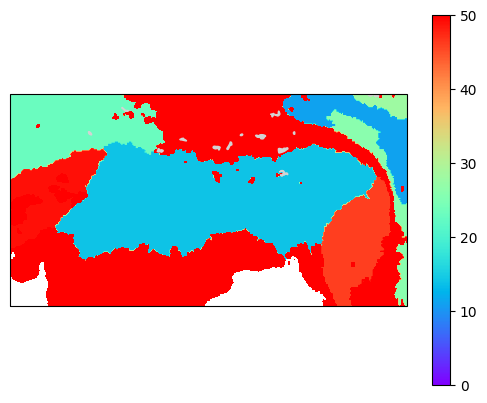

In [4]:
left = 70
right = 100
bottom = 19
top = 35
basin(left, right, bottom, top)

14.0: 20689
23.0: 7160
46.0: 4580
49.0: 3596
--: 3430
11.0: 3314
58.0: 3048
53.0: 2475
26.0: 1851
105.0: 1694
148.0: 1216


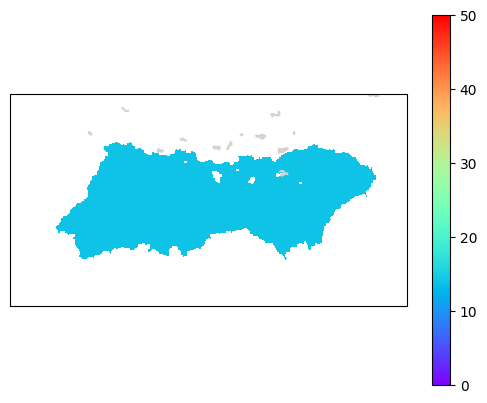

In [9]:
def ganges_rivnum():
    #
    left = 70
    right = 100
    bottom = 19
    top = 35
    #
    glbdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    #
    SUF = '.gl5'
    dtype = 'float32'
    gl5shape = (2160, 4320)
    #
    resolution = 12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    
    #------------------------------------------------------------------------------------------------------------------------

    # river num
    rivnum = np.fromfile(f'{glbdir}/dat/riv_num_/rivnum.CAMA.gl5', dtype='float32').reshape(gl5shape)
    rivnum_cropped = rivnum[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    rivnum_cropped = np.ma.masked_where(rivnum_cropped == 0, rivnum_cropped)
    
    # sort number of same basin_rivnum in grids
    unique, counts = np.unique(rivnum_cropped, return_counts=True)
    sorted_indices = np.argsort(-counts)
    sorted_unique = unique[sorted_indices]
    sorted_counts = counts[sorted_indices]

    for value, count in zip(sorted_unique, sorted_counts):
        if count > 1000:
            print(f"{value}: {count}")

    rivnum_largest = np.ma.masked_where(rivnum_cropped != sorted_unique[0], rivnum_cropped)
    
    # plot
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.add_feature(cfea.LAKES, color='#d3d3d3')
    im = ax.imshow(rivnum_largest, extent=img_extent, transform=projection, cmap='rainbow', vmin=0, vmax=50)
    fig.colorbar(im, ax=ax)

ganges_rivnum()

In [10]:
def ganges_prcp():
    pass

def ganges_runoff():
    pass

def ganges_discharge():
    pass